In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define Pauli matrices
sigma0 = np.array([[1, 0], [0, 1]], dtype=complex)
sigma1 = np.array([[0, 1], [1, 0]], dtype=complex)
sigma2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigma3 = np.array([[1, 0], [0, -1]], dtype=complex)

# Define gamma matrices: Gamma_{ij} = sigma_i \otimes sigma_j.
def gamma(i, j):
    mats = [sigma0, sigma1, sigma2, sigma3]
    return np.kron(mats[i], mats[j])

# Precompute the gamma matrices used in the Hamiltonian.
Gamma_03 = gamma(0, 3)
Gamma_13 = gamma(1, 3)
Gamma_30 = gamma(3, 0)
Gamma_12 = gamma(1, 2)
Gamma_31 = gamma(3, 1)
Gamma_21 = gamma(2, 1)
Gamma_32 = gamma(3, 2)

# Define the Hamiltonian h(k) as given.
def hamiltonian(kx, ky, alpha, beta, delta):
    term1 = 0.5 * Gamma_13
    term2 = (alpha / 2.0) * (np.cos(kx) + np.cos(ky)) * (Gamma_30 + Gamma_03)
    term3 = (Gamma_12 + Gamma_31) * np.sin(kx)
    term4 = (Gamma_21 + Gamma_32) * np.sin(ky)
    term5 = - Gamma_03
    term6 = (beta / 2.0) * np.cos(kx) * (np.cos(ky) - delta) * (Gamma_03 - Gamma_30)
    return term1 + term2 + term3 + term4 + term5 + term6


In [2]:
# Function to extract the inversion eigenvalue of an eigenstate.
def inversion_eigenvalue(psi):
    # Calculate the expectation value <psi|Gamma_03|psi>.
    val = np.vdot(psi, Gamma_03.dot(psi))
    # In an inversion-symmetric setting, this should be +1 or -1.
    if np.abs(val - 1) < 1e-6:
        return +1
    elif np.abs(val + 1) < 1e-6:
        return -1
    else:
        # In case of numerical imprecision, return the sign of the real part.
        return np.sign(val.real)

# High–symmetry points in the Brillouin zone.
points = {
    "Gamma": (0, 0),
    "X": (np.pi, 0),
    "Y": (0, np.pi),
    "M": (np.pi, np.pi)
}

# Two sets of parameters to analyze.
params = {
    "(-1.5, 0, 0)": (-1.5, 0.0, 0.0),
    "(-1.5, 1.5, -1)": (-1.5, 1.5, -1.0)
}

# Store results: results[param_set][point] = [inversion eigenvalue of band 1, band 2].
results = {}

for key, (alpha, beta, delta) in params.items():
    results[key] = {}
    for pt_name, (kx, ky) in points.items():
        H = hamiltonian(kx, ky, alpha, beta, delta)
        # Diagonalize H.
        eigvals, eigvecs = np.linalg.eig(H)
        # Sort eigenvalues and corresponding eigenvectors (by real part).
        idx = np.argsort(eigvals.real)
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        # Select the two lowest eigenstates (occupied bands).
        inv_eigs = []
        for i in range(2):
            psi = eigvecs[:, i]
            inv_val = inversion_eigenvalue(psi)
            inv_eigs.append(inv_val)
        results[key][pt_name] = inv_eigs

# Print the results as a table.
print("High–Symmetry Point\tParameter Set\tOccupied Band Inversion Eigenvalues")
for key, pts in results.items():
    for pt_name, inv_vals in pts.items():
        print(f"{pt_name:10s}\t{key:20s}\t{inv_vals}")


High–Symmetry Point	Parameter Set	Occupied Band Inversion Eigenvalues
Gamma     	(-1.5, 0, 0)        	[1, 1]
X         	(-1.5, 0, 0)        	[1, 1]
Y         	(-1.5, 0, 0)        	[1, 1]
M         	(-1.5, 0, 0)        	[-1, 1]
Gamma     	(-1.5, 1.5, -1)     	[1, -1]
X         	(-1.5, 1.5, -1)     	[1, 1]
Y         	(-1.5, 1.5, -1)     	[1, 1]
M         	(-1.5, 1.5, -1)     	[-1, 1]


In [3]:
# Compute the Wilson loop along kx for fixed ky.
def compute_wilson_loop(ky, alpha, beta, delta, Nk=201):
    # Discretize kx in [0, 2pi) (periodic boundary conditions).
    kx_vals = np.linspace(0, 2*np.pi, Nk, endpoint=False)
    
    # Compute occupied state matrices along kx.
    # Each U is a 4x2 matrix whose columns are the two occupied eigenstates.
    U_list = []
    for kx in kx_vals:
        H = hamiltonian(kx, ky, alpha, beta, delta)
        eigvals, eigvecs = np.linalg.eig(H)
        # Sort by real part so that the two lowest eigenvalues (occupied) come first.
        idx = np.argsort(eigvals.real)
        U = eigvecs[:, idx[:2]]
        U_list.append(U)
    
    # --- Fixed-reference gauge fixing ---
    # Use the occupied subspace at kx=0 as a reference.
    U0 = U_list[0]
    for j in range(1, Nk):
        # Compute overlap with the fixed reference.
        O_ref = U0.conj().T @ U_list[j]
        # Polar-decompose O_ref to get a unitary V (i.e. O_ref = V * positive Hermitian).
        U_svd, s, Vh = np.linalg.svd(O_ref)
        V = U_svd @ Vh
        # Adjust U_list[j] so that its phase is referenced to U0.
        U_list[j] = U_list[j] @ V.conj().T

    # --- Compute the Wilson loop as the product of overlap matrices ---
    W = np.eye(2, dtype=complex)
    for j in range(Nk):
        jp = (j + 1) % Nk  # next index (with periodic closure)
        # Overlap matrix from kx[j] to kx[jp].
        O = U_list[j].conj().T @ U_list[jp]
        W = np.dot(W, O)  # accumulate product (note the ordering)
    
    # Diagonalize the Wilson loop operator.
    wilson_eigs, _ = np.linalg.eig(W)
    return wilson_eigs

# Define parameter sets.
param_sets = {
    "(-1.5, 0, 0)": (-1.5, 0.0, 0.0),
    "(-1.5, 1.5, -1)": (-1.5, 1.5, -1.0)
}

# Fixed ky values.
ky_vals = {"ky=0": 0, "ky=pi": np.pi}

# Compute and display Wilson loop eigenvalue types.
results = {}
for param_label, (alpha, beta, delta) in param_sets.items():
    results[param_label] = {}
    for ky_label, ky in ky_vals.items():
        eigs = compute_wilson_loop(ky, alpha, beta, delta, Nk=201)
        # Extract phases (angles) in the interval [0, 2pi).
        phases = np.angle(eigs)
        phases = np.mod(phases, 2*np.pi)
        # Decide whether each eigenvalue is pinned (close to 0 or pi phase) or not.
        def pin_label(phi):
            # If phi is close to 0 or 2pi, label as +1.
            if np.abs(phi) < 1e-3 or np.abs(phi - 2*np.pi) < 1e-3:
                return "+1"
            # If phi is close to pi, label as -1.
            elif np.abs(phi - np.pi) < 1e-3:
                return "-1"
            else:
                return None
        labels = [pin_label(phi) for phi in phases]
        # If both eigenvalues got a label, report them (after sorting by phase).
        if all(lbl is not None for lbl in labels):
            sorted_labels = sorted(labels)
            status = f"({sorted_labels[0]},{sorted_labels[1]})"
        else:
            status = "Complex conjugate pair"
        results[param_label][ky_label] = {"wilson_eigs": eigs, "status": status}

# Print results in a table.
print("Wilson Loop Eigenvalue Types along kx (fixed ky):")
print("-----------------------------------------------------")
print("{:<20s} {:<10s} {:<30s}".format("Parameter Set", "ky", "Wilson Loop Eigenvalue Type"))
for param_label, ky_data in results.items():
    for ky_label, data in ky_data.items():
        print("{:<20s} {:<10s} {:<30s}".format(param_label, ky_label, data["status"]))


Wilson Loop Eigenvalue Types along kx (fixed ky):
-----------------------------------------------------
Parameter Set        ky         Wilson Loop Eigenvalue Type   
(-1.5, 0, 0)         ky=0       (+1,+1)                       
(-1.5, 0, 0)         ky=pi      (+1,-1)                       
(-1.5, 1.5, -1)      ky=0       (+1,-1)                       
(-1.5, 1.5, -1)      ky=pi      (+1,-1)                       


In [4]:
def get_occupied_states(ky, alpha, beta, delta, Nk=201):
    """
    For a fixed ky, discretize kx and compute the occupied eigenstates (lowest two)
    at each kx.
    Returns the discretized kx values and a list of occupied state matrices U (4x2 arrays).
    """
    # Discretize kx over [0, 2pi) with periodic boundary conditions.
    kx_vals = np.linspace(0, 2*np.pi, Nk, endpoint=False)
    U_list = []
    for kx in kx_vals:
        H = hamiltonian(kx, ky, alpha, beta, delta)
        eigvals, eigvecs = np.linalg.eig(H)
        # Sort eigenvalues (and eigenvectors) by the real part.
        idx = np.argsort(eigvals.real)
        U = eigvecs[:, idx[:2]]  # Select the two lowest eigenstates (occupied bands)
        U_list.append(U)
    return kx_vals, U_list


In [5]:
def gauge_fix(U_list):
    """
    Fix the gauge along the kx path by referencing all states to U(kx=0).
    For each U in the list, adjust its phase such that its overlap with U_list[0] is maximized.
    """
    U0 = U_list[0]
    for j in range(1, len(U_list)):
        O_ref = U0.conj().T @ U_list[j]
        # Polar-decompose the overlap to obtain its unitary part.
        U_svd, s, Vh = np.linalg.svd(O_ref)
        V = U_svd @ Vh
        U_list[j] = U_list[j] @ V.conj().T
    return U_list


In [6]:
def compute_wilson_operator(U_list):
    """
    Compute the Wilson loop operator along the discretized kx path.
    The Wilson loop is the product of the overlap matrices between neighboring occupied states.
    """
    Nk = len(U_list)
    W = np.eye(U_list[0].shape[1], dtype=complex)
    for j in range(Nk):
        jp = (j + 1) % Nk  # next index (with periodic closure)
        O = U_list[j].conj().T @ U_list[jp]
        W = W @ O  # accumulate the product
    return W


In [7]:
def extract_wannier_centers(W):
    """
    Diagonalize the Wilson loop operator W and extract its eigenphases.
    These eigenphases (modulo 2pi) are the Wannier centers.
    """
    eigvals, _ = np.linalg.eig(W)
    phases = np.angle(eigvals)  # phases in (-pi, pi]
    phases.sort()  # sort them for consistency (ordering is arbitrary)
    return phases


In [8]:
def compute_wilson_loop_fixed_ky(ky, alpha, beta, delta, Nk=201):
    """
    For a fixed ky, compute the Wilson loop along kx and extract the Wannier centers.
    """
    kx_vals, U_list = get_occupied_states(ky, alpha, beta, delta, Nk)
    U_list = gauge_fix(U_list)
    W = compute_wilson_operator(U_list)
    phases = extract_wannier_centers(W)
    return phases


In [9]:
def compute_wannier_centers_vs_ky(alpha, beta, delta, Nkx=201, Nky=101):
    """
    Sweep ky over [-pi, pi) and compute the Wilson loop eigenphases (Wannier centers) for each ky.
    Returns an array of ky values and the corresponding Wannier centers (eigenphases).
    """
    ky_vals = np.linspace(-np.pi, np.pi, Nky, endpoint=False)
    centers = []
    for ky in ky_vals:
        phases = compute_wilson_loop_fixed_ky(ky, alpha, beta, delta, Nk=Nkx)
        centers.append(phases)
    centers = np.array(centers)  # shape (Nky, 2)
    return ky_vals, centers

def plot_wannier_centers_vs_ky(alpha, beta, delta, Nkx=201, Nky=101):
    """
    Plot the Wannier centers (Wilson loop eigenphases) as a function of ky.
    """
    ky_vals, centers = compute_wannier_centers_vs_ky(alpha, beta, delta, Nkx, Nky)
    plt.figure(figsize=(8, 6))
    plt.plot(ky_vals, centers[:, 0], 'o-', label='Wannier Center 1')
    plt.plot(ky_vals, centers[:, 1], 's-', label='Wannier Center 2')
    plt.xlabel(r'$k_y$')
    plt.ylabel('Wilson Loop Eigenphase (radians)')
    plt.title(f'Wannier Centers vs. $k_y$ for (alpha, beta, delta)=({alpha}, {beta}, {delta})')
    plt.legend()
    plt.grid(True)
    plt.show()
    return ky_vals, centers


In [10]:
def compute_winding(centers):
    """
    Unwrap the phases along ky for each Wannier center and compute the net winding.
    The winding number for a band is given by the net phase change divided by 2pi.
    """
    centers_unwrapped = np.unwrap(centers, axis=0)
    net_change = centers_unwrapped[-1, :] - centers_unwrapped[0, :]
    winding = np.round(net_change / (2 * np.pi)).astype(int)
    return winding


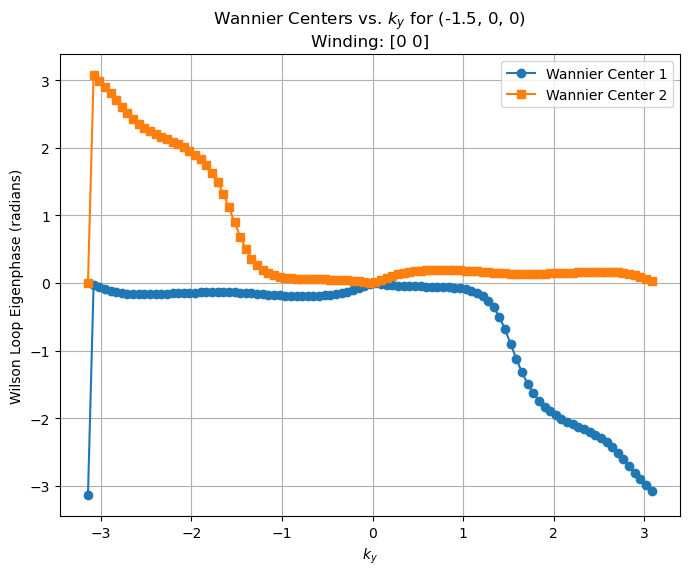

For parameter set (-1.5, 0, 0), net winding numbers are: [0 0]
=> Total Chern number = 0


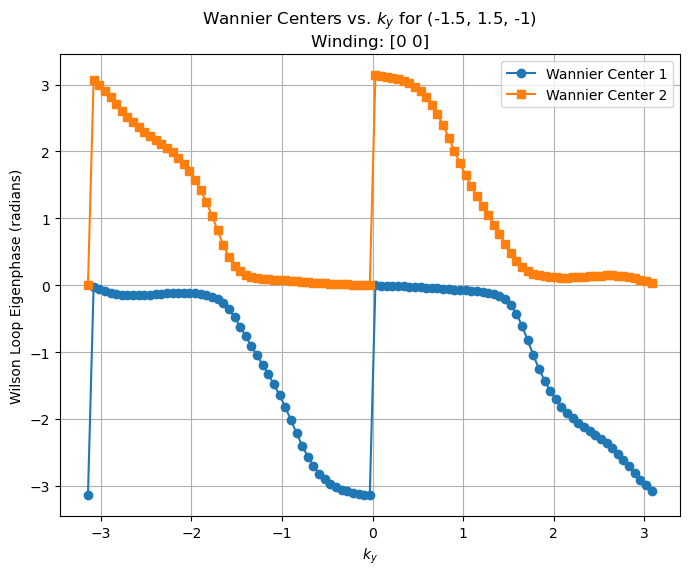

For parameter set (-1.5, 1.5, -1), net winding numbers are: [0 0]
=> Total Chern number = 0


In [11]:
# Define the parameter sets.
param_sets = {
    "(-1.5, 0, 0)": (-1.5, 0.0, 0.0),
    "(-1.5, 1.5, -1)": (-1.5, 1.5, -1.0)
}

# Loop over parameter sets, compute and plot the Wannier centers, and determine the winding.
for label, (alpha, beta, delta) in param_sets.items():
    ky_vals, centers = compute_wannier_centers_vs_ky(alpha, beta, delta, Nkx=201, Nky=101)
    winding = compute_winding(centers)
    
    # Plot the evolution of the Wannier centers versus ky.
    plt.figure(figsize=(8, 6))
    plt.plot(ky_vals, centers[:, 0], 'o-', label='Wannier Center 1')
    plt.plot(ky_vals, centers[:, 1], 's-', label='Wannier Center 2')
    plt.xlabel(r'$k_y$')
    plt.ylabel('Wilson Loop Eigenphase (radians)')
    plt.title(f'Wannier Centers vs. $k_y$ for {label}\nWinding: {winding}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    print(f"For parameter set {label}, net winding numbers are: {winding}")
    print("=> Total Chern number =", np.sum(winding))
